# Exercise 2

Recall that the *Geometric Brownian Motion* (GBM) model of stock prices is defined by
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
and it has solution

$$
S_t = S_0 \exp\left[
\left(
\mu - \frac{\sigma^2}{2}
\right) t
+ \sigma W_t
\right]
$$
## Question 1 ## 
Simulate 100 GBM sample paths, each of which has length $201$ and $S_0 = 1, \mu=0.08, \sigma=0.06$. Take the time step as $\Delta t = 1/200$.

**Hint**
1. The 200 steps of each path corresponds to $t=0.005\times1, 0.005\times2, \dots, 0.005\times200$.
2. calculate $\mu + \frac{\sigma^2}{2} = 0.08 + \frac{0.06^2}{2} = 0.818$.
3. simulate $\left(\mu - \frac{\sigma^2}{2}\right) t$ as a sequence $A$ of 200 items
   - $A_1 = 0.818 \times 1 \times 0.05$
   - $A_2 = 0.818 \times 2 \times 0.005$
   - ...
   - $A_{200} = 0.818 \times 200 \times 0.005$
4. simulate $W_t$ as another sequence of 200 items:
   1. simulate 200 standard normal random variables $x_1, x_2, \dots, x_{200}$ using scipy.stats.norm.rvs(size=200)
   2. Generate the $W_t$ sequence as
      - $W_1 = \sqrt{\Delta t} \times x_1$
      - $W_2 = \sqrt{\Delta t} \times (x_1 + x_2)$
      - ...
      - $W_{200} = \sqrt{\Delta t} \times (x_1 + x_2 + \cdots + x_{200})$

      Note: $\sqrt{\Delta t} = \sqrt{0.005} \approx 0.0707$. Use numpy.sqrt
   3. Use $\sigma = 0.06, S_0 = 1$ and simulate $S_1, S_2, \dots, S_{200}$ as
      - $S_1 = \exp(A_1 + 0.06\times W_1)$
      - $S_2 = \exp(A_2 + 0.06\times W_2)$
      - ...
      - $S_{200} = \exp(A_{200} + 0.06\times W_{200})$
        
       Use numpy.exp for the $\exp$ function.
    4. Assign $S_0 = 1$.


**Solution**:

In [13]:
paths

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.0025015 , 0.99980441, 1.00314384, ..., 1.00149969, 1.00041278,
        0.99939591],
       [0.99688932, 0.99841201, 1.00207805, ..., 1.002545  , 1.00105121,
        0.99495031],
       ...,
       [1.10890033, 0.98910914, 1.05860933, ..., 1.16305564, 1.05975815,
        1.09598133],
       [1.11835414, 0.99241298, 1.0618524 , ..., 1.16287816, 1.06487453,
        1.09918506],
       [1.11936715, 0.99046753, 1.05395221, ..., 1.16520184, 1.07306375,
        1.09208348]])

Simulation complete (Efficient Vectorized Version).
Shape of paths array: (201, 100)


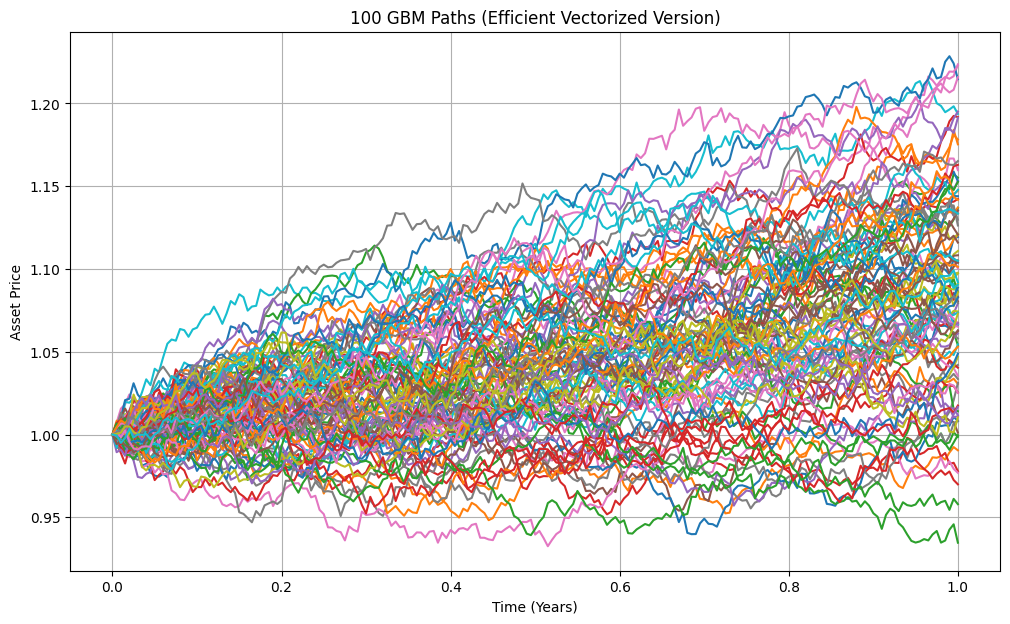

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters
num_steps = 200
num_paths = 100
path_length = num_steps + 1
S0 = 1.0
mu = 0.08
sigma = 0.06
T = 1.0
dt = T / num_steps

# --- Calculations
drift = (mu - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt)

# --- Vectorized Simulation ---

# Use np.zeros which is more standard than np.nan for this
paths = np.zeros((path_length, num_paths))
paths[0, :] = S0

# Generate all random shocks for all paths and steps in one go
np.random.seed(42)
random_shocks = np.random.standard_normal((num_steps, num_paths))

# A single loop over time steps, updating all paths simultaneously
for t in range(1, path_length):
    paths[t] = paths[t-1] * np.exp(drift + diffusion * random_shocks[t-1])

print("Simulation complete (Efficient Vectorized Version).")
print(f"Shape of paths array: {paths.shape}")


# --- Plotting the Results ---
time_vector = np.linspace(0, T, path_length)

plt.figure(figsize=(12, 7))
plt.plot(time_vector, paths)
plt.title(f'{num_paths} GBM Paths (Efficient Vectorized Version)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

## Question 2 ##
Calibrate a GBM model to each of the 100 sample paths.

**Hint**
Suppose we are calibrating the model to the sample path $S_0, S_1, S_2, \dots, S_{200}$.
1. Compute the sequence
   - $a_1 = \ln S_1 - \ln S_0$
   - $a_2 = \ln S_2 - \ln S_1$
   - ...
   - $a_{200} = \ln S_{200} - \ln S_{199}$

    Use numpy.log for the $\ln$ function.
2. Compute the mean and the standard deviation of $a_1, a_2, \dots, a_{200}$. Call the mean $\bar a$ and the standard deviation $\hat a$. Use bootstrapping for this purpose - simply adding up all the $a$'s and diving the sum by 200 will just give us $(\ln S_{200} - \ln S_0)/200$. We want to use all the $a$'s! Follow these steps:
   1. randomly choose, with replacement, 100 items from $a_1, a_2, \dots, a_{200}$. Use numpy.random.Generator.choice for this. Call the selected numbers $b_1, b_2, \dots, b_{100}$. This is a bootstrap sample. Call it bootstrap sample 1.
   2. calculate the average of bootstrap sample 1 and call the result $m_1$: $m_1 = (b_1 + b_2 + \cdots + b_{100})/100$.
   3. calculate the average of the squares of bootstrap sample 1 and call the result $q_1$: $q_1 = (b_1^2 + b_2^2 + \cdots + b_{100}^2)/100$.
   4. In the same way as we created bootstrap sample 1, create bootstrap sample 2, 3, 4, ..., 10.
   5. Calculate the average of each of the bootstrap samples and the average of the squares of each of the samples. Call them $m_2, m_3, \dots, m_{10}$ and $q_2, q_3, \dots, q_{10}$
3. Calculate $\bar a$ as
   $$\bar a = {m_1 + m_2 + \cdots + m_{10} \over 10}$$
4. Calculate $\hat a$ as
   $$\hat a = \sqrt{{q_1 + q_2 + \cdots + q_{10} \over 10} - \bar{a}^2}$$
5. Now estimate the model parameter $\sigma$ as
   $$\sigma = \frac{\hat a}{\sqrt{\Delta t}}$$
6. Estimate the model parameter $\mu$ as
   $$\mu = \frac{\bar{a}}{\Delta t} + \frac{\hat{a}^2}{2\times\Delta t}$$
7. Now the model parameters $\mu$ and $\sigma$ have been estimated, model calibration is complete.

In [51]:
class GBM:
    def __init__(self):
        self.mu = np.nan
        self.sigma = np.nan
        self.rng = np.random.default_rng()
        
    def calibrate(self, trajectory, Dt):
        # Step 1: Compute log returns
        log_returns = np.diff(np.log(trajectory))  # shape: (len - 1,)

        # Step 2: Sample statistics
        mean_r = np.mean(log_returns)
        var_r = np.var(log_returns, ddof=1)

        # Step 3: Estimate σ
        self.sigma = np.sqrt(var_r) / np.sqrt(Dt)

        # Step 4: Estimate μ
        self.mu = (mean_r / Dt) + 0.5 * self.sigma**2


Dt = 1.0 / 200.0
num_paths = paths.shape[1]

for i in range(num_paths):
    model = GBM()
    model.calibrate(paths[:, i], Dt)
    print(f"Path {i+1:>2}: μ ≈ {model.mu:.4f}, σ ≈ {model.sigma:.4f}")

Path  1: μ ≈ 0.1145, σ ≈ 0.0589
Path  2: μ ≈ -0.0082, σ ≈ 0.0518
Path  3: μ ≈ 0.0545, σ ≈ 0.0633
Path  4: μ ≈ 0.1345, σ ≈ 0.0533
Path  5: μ ≈ 0.0610, σ ≈ 0.0582
Path  6: μ ≈ 0.0034, σ ≈ 0.0674
Path  7: μ ≈ 0.0975, σ ≈ 0.0610
Path  8: μ ≈ 0.0430, σ ≈ 0.0595
Path  9: μ ≈ 0.1071, σ ≈ 0.0629
Path 10: μ ≈ 0.1789, σ ≈ 0.0598
Path 11: μ ≈ 0.1008, σ ≈ 0.0582
Path 12: μ ≈ 0.1637, σ ≈ 0.0648
Path 13: μ ≈ 0.1301, σ ≈ 0.0597
Path 14: μ ≈ -0.0206, σ ≈ 0.0591
Path 15: μ ≈ 0.1284, σ ≈ 0.0548
Path 16: μ ≈ 0.1044, σ ≈ 0.0555
Path 17: μ ≈ 0.2039, σ ≈ 0.0640
Path 18: μ ≈ 0.0348, σ ≈ 0.0597
Path 19: μ ≈ 0.0950, σ ≈ 0.0586
Path 20: μ ≈ 0.0817, σ ≈ 0.0611
Path 21: μ ≈ 0.1963, σ ≈ 0.0611
Path 22: μ ≈ 0.1304, σ ≈ 0.0609
Path 23: μ ≈ 0.0843, σ ≈ 0.0587
Path 24: μ ≈ 0.1773, σ ≈ 0.0605
Path 25: μ ≈ 0.1448, σ ≈ 0.0662
Path 26: μ ≈ 0.1021, σ ≈ 0.0651
Path 27: μ ≈ -0.0216, σ ≈ 0.0607
Path 28: μ ≈ 0.1237, σ ≈ 0.0575
Path 29: μ ≈ 0.0946, σ ≈ 0.0590
Path 30: μ ≈ 0.0546, σ ≈ 0.0566
Path 31: μ ≈ 0.0661, σ ≈ 0.0611
Path 

## Question 3 ##
calibrate a GBM model to the provided S&P500 series.

**Solutions**: We first read the prices data into an array and then use GBM.calibrate to calibrate the model.

In [52]:
import csv
import pandas as pd
from contextlib import closing

# Your code goes here
SP500_data = pd.read_csv('SP500.csv', 
                         sep='\t',
                         header=None,
                         names=['Date', 'Close'],
                         parse_dates=['Date'])     # parse 'Date' as datetime


In [53]:
SP500_data.head()

,Date,Close
0,2019-01-02,2473.399902
1,2019-01-03,2448.399902
2,2019-01-04,2528.600098
3,2019-01-06,2537.000000
4,2019-01-07,2549.800049


In [56]:
Dt = 1.0 / 250
prices_SP500 = np.array(SP500_data['Close'])

np.random.seed(42)  # For reproducibility
model = GBM()
model.calibrate(prices_SP500, Dt)
print(f"Parameters: μ ≈ {model.mu:.4f}, σ ≈ {model.sigma:.4f}")

# model parameters: 0.2505601417897917, 0.20955993355868519

Parameters: μ ≈ 0.1987, σ ≈ 0.2082


--- Calibrating each path using bootstrapping ---
Calibrated path 20/100...
Calibrated path 40/100...
Calibrated path 60/100...
Calibrated path 80/100...
Calibrated path 100/100...

--- Calibration Complete ---
Average estimated mu: 0.0851
Average estimated sigma: 0.0598


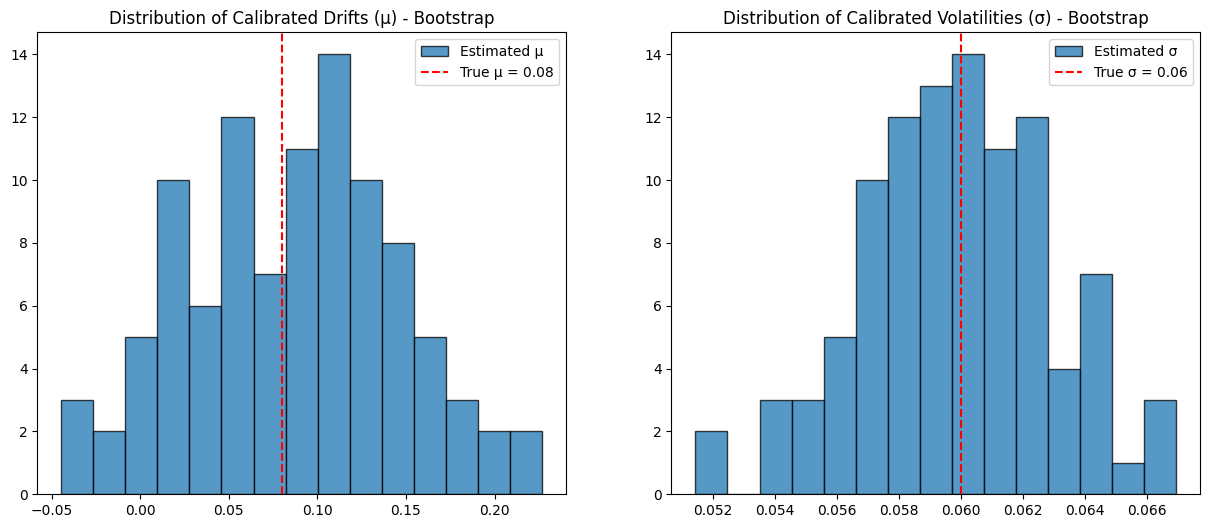

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GbmBootstrapCalibrator:
    """
    Calibrates GBM parameters using a bootstrapping method on log-returns.
    """
    def calibrate(self, trajectory, Dt, rng, num_bootstraps=10):
        """
        Calibrates mu and sigma from a single time series trajectory.

        Args:
            trajectory (np.ndarray): A 1D array of asset prices.
            Dt (float): The time step, Δt.
            rng (np.random.Generator): The random number generator to use.
            num_bootstraps (int): The number of bootstrap iterations.

        Returns:
            tuple: A tuple containing the estimated (mu, sigma).
        """
        # Step 1: Compute log returns
        log_returns = np.diff(np.log(trajectory))
        
        # Lists to store the moments from each bootstrap iteration
        bootstrap_means = []
        bootstrap_mean_squares = []
        
        # Step 2: Perform bootstrapping
        for _ in range(num_bootstraps):
            # Create a bootstrap sample of the SAME size, with replacement
            bootstrap_sample = rng.choice(
                log_returns, 
                size=len(log_returns), 
                replace=True
            )
            
            # Calculate and store the moments of this sample
            bootstrap_means.append(np.mean(bootstrap_sample))
            bootstrap_mean_squares.append(np.mean(bootstrap_sample**2))
        
        # Step 3: Average the moments from all bootstrap iterations
        avg_mean = np.mean(bootstrap_means)
        avg_mean_square = np.mean(bootstrap_mean_squares)
        
        # Step 4: Calculate the final parameter estimates
        std_of_returns = np.sqrt(avg_mean_square - avg_mean**2)
        
        est_sigma = std_of_returns / np.sqrt(Dt)
        est_mu = avg_mean / Dt + 0.5 * est_sigma**2
        
        return est_mu, est_sigma

# --- Corrected Usage ---

Dt = 1.0 / 200.0
K = paths.shape[1] # K is the number of paths

# FIX: Create ONE random number generator OUTSIDE the loop
rng = np.random.default_rng(seed=42)

# FIX: Create ONE calibrator object to reuse
calibrator = GbmBootstrapCalibrator()

# FIX: Create lists to store the results for analysis
estimated_mus_boot = []
estimated_sigmas_boot = []

print("--- Calibrating each path using bootstrapping ---")
for i in range(K):
    # Calibrate on the i-th path, passing the rng object
    mu, sigma = calibrator.calibrate(paths[:, i], Dt, rng)
    
    # Store the results
    estimated_mus_boot.append(mu)
    estimated_sigmas_boot.append(sigma)
    
    # Optionally print progress
    if (i + 1) % 20 == 0:
        print(f"Calibrated path {i+1}/{K}...")

print("\n--- Calibration Complete ---")
print(f"Average estimated mu: {np.mean(estimated_mus_boot):.4f}")
print(f"Average estimated sigma: {np.mean(estimated_sigmas_boot):.4f}")


# --- Final Analysis: Plotting the results ---
mu_true, sigma_true = 0.08, 0.06
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(estimated_mus_boot, bins=15, alpha=0.75, edgecolor='black', label='Estimated μ')
ax1.axvline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true}')
ax1.set_title('Distribution of Calibrated Drifts (μ) - Bootstrap')
ax1.legend()
ax2.hist(estimated_sigmas_boot, bins=15, alpha=0.75, edgecolor='black', label='Estimated σ')
ax2.axvline(sigma_true, color='red', linestyle='--', label=f'True σ = {sigma_true}')
ax2.set_title('Distribution of Calibrated Volatilities (σ) - Bootstrap')
ax2.legend()
plt.show()

In [ ]:
import csv
from contextlib import closing

prices = []
with closing(open('SP500.csv')) as datafile:
    reader = csv.DictReader(datafile, fieldnames=["date", "price"], delimiter='\t')
    for row in reader:
        prices.append(float(row['price']))
model = GBM(seed=42);
model.calibrate(prices, 1/250);
print(F"model parameters: {model.mu}, {model.sigma}")


In [58]:
import csv
import numpy as np

class GbmBootstrapCalibrator:
    """
    Calibrates GBM parameters using a bootstrapping method on log-returns.
    """
    def calibrate(self, trajectory, Dt, rng, num_bootstraps=100):
        """
        Calibrates mu and sigma from a single time series trajectory.

        Args:
            trajectory (np.ndarray): A 1D array of asset prices.
            Dt (float): The time step, Δt, in years.
            rng (np.random.Generator): The random number generator to use.
            num_bootstraps (int): The number of bootstrap iterations.

        Returns:
            tuple: A tuple containing the estimated (mu, sigma).
        """
        # Convert list to numpy array if it isn't already
        trajectory = np.asarray(trajectory)
        
        # Calculate the log-returns
        log_returns = np.diff(np.log(trajectory))
        
        bootstrap_means = []
        bootstrap_mean_squares = []
        
        # Perform bootstrapping
        for _ in range(num_bootstraps):
            bootstrap_sample = rng.choice(
                log_returns, 
                size=len(log_returns), 
                replace=True
            )
            bootstrap_means.append(np.mean(bootstrap_sample))
            bootstrap_mean_squares.append(np.mean(bootstrap_sample**2))
        
        avg_mean = np.mean(bootstrap_means)
        avg_mean_square = np.mean(bootstrap_mean_squares)
        
        std_of_returns = np.sqrt(avg_mean_square - avg_mean**2)
        
        # Annualize the parameters
        est_sigma = std_of_returns / np.sqrt(Dt)
        est_mu = avg_mean / Dt + 0.5 * est_sigma**2
        
        return est_mu, est_sigma

In [60]:
FILE_NAME = 'SP500.csv'
TRADING_DAYS_PER_YEAR = 252.0  # 252 is more standard than 250
DT = 1.0 / TRADING_DAYS_PER_YEAR

prices = []
with open(FILE_NAME, mode='r', newline='') as datafile:
    reader = csv.DictReader(datafile, fieldnames=["date", "price"], delimiter='\t')
    for row in reader:
        prices.append(float(row['price']))
        
# 1. Create the random number generator ONCE, using the seed.
rng = np.random.default_rng(seed=42)

# 2. Instantiate the correct, reliable calibrator class.
calibrator = GbmBootstrapCalibrator()

# 3. Call its 'calibrate' method, passing the rng object as required.
#    The method now returns the parameters instead of modifying the object.
mu_calibrated, sigma_calibrated = calibrator.calibrate(prices, DT, rng)

# 4. Print the results in a clear and descriptive format.
print("\n--- Calibration Results ---")
print(f"Based on {len(prices) - 1} daily returns.")
print(f"Annualized Drift (μ):     {mu_calibrated:.6f}  ({mu_calibrated:.2%})")
print(f"Annualized Volatility (σ): {sigma_calibrated:.6f}  ({sigma_calibrated:.2%})")


--- Calibration Results ---
Based on 749 daily returns.
Annualized Drift (μ):     0.205218  (20.52%)
Annualized Volatility (σ): 0.208910  (20.89%)
